In [12]:
#Importamos algunas cosas

import numpy as np
import matplotlib.pyplot as plt

from qiskit.providers.ibmq import least_busy
import qiskit
from qiskit.visualization import plot_histogram

# Needed for functions
import time

import qiskit.quantum_info as qi
from qiskit.providers.aer import noise
from qiskit.compiler import assemble

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate

from qiskit.quantum_info import Choi, Kraus
from qiskit.extensions import HGate, XGate
import qiskit.quantum_info.operators.channel.transformations as qtrans
import itertools
import csv
#import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor

from qiskit import QuantumCircuit, QuantumRegister,execute, Aer



#Definimos las matrices de Pauli
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

## Iniciar Sesión IBM

In [2]:
# Primero iniciamos sesion
from qiskit import IBMQ
# Cargando cuenta de IBM (para realizar esto es necesaria una cuenta de IBM, preferiblemente esta sección se peude cargar desde IBM quantum lab)
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

#Entrar aqui https://quantum-computing.ibm.com/
#con el correo @ciencias para ver los trabajos enviados y demás

C:\Users\tbasi\AppData\Local\Temp\ipykernel_12060\1003815817.py:4: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


# Funciones para crear el circuito

In [20]:
def alphas_a_circ(alphas):
    '''Dadas las alphas (que en el artículo se llaman k) crear
    el circuito del canal de Pauli correspondiente.'''
    al0,al1,al2,al3 = alphas
    #Calculamos los ángulos para crear el estado correspondiente sobre ancilla
    th0 = np.angle(np.sqrt(al0)+1j*np.sqrt(al1)) - np.angle(np.sqrt(al2)+1j*np.sqrt(al3))
    th1 = 2*np.arccos(np.sqrt(al0+al1))
    th2 = np.angle(np.sqrt(al0)+1j*np.sqrt(al1)) + np.angle(np.sqrt(al2)+1j*np.sqrt(al3))
    
    # Hacemos el circuito.
    qreg_q = QuantumRegister(3, 'q')  #3 registros cuánticos
    circ = QuantumCircuit(qreg_q)
    
    #Le ponemos las puertas para crear el estado de qbits de ancilla
    circ.ry(th1,1)
    circ.ry(th0,2)
    circ.cz(1,2)
    circ.ry(th2,2)
    
    #Agregamos las puertas controladas sobre el qubit principal
    c2y = YGate.control(YGate(),num_ctrl_qubits=2,ctrl_state='01')
    c2x = XGate.control(XGate(),num_ctrl_qubits=2,ctrl_state='10')
    c2z = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    circ.append(c2x, [1, 2, 0])
    circ.append(c2y, [1, 2, 0])
    circ.append(c2z, [1, 2, 0])

    return(circ)


def lambdas_a_alphas(lambdas):
    '''Convertir las lambdas del tetraedro a las alphas'''
    l1,l2,l3 = lambdas
    al1 =  1/4*(1+l1-l2-l3)
    al2 = 1/4*(1-l1+l2-l3)
    al3 = 1/4*(1-l1-l2+l3)
    al0=1-al1-al2-al3
    return([al0,al1,al2,al3])
    

def lambdas_a_circ(lambdas):
    '''Crear un circuito a partir de las lambdas'''
    return(alphas_a_circ(lambdas_a_alphas(lambdas)))

#Vemos un ejemplo:

#lambdas_a_circ([0.4,0.5,0.3]).draw('mpl')


### Crear puntos que vamos a simular en el tetraedro.

In [21]:
def crear_puntos(cantidad):
    '''Crear puntos en el tetraedro'''
    conjunto=[]

    #Creamos los puntos de lambdas 1, 2 y 3.
    l1s = np.linspace(-1,1,cantidad)
    l2s = np.linspace(-1,1,cantidad)
    l3s = np.linspace(-1,1,cantidad)

    #Vamos iterando sobre cada punto
    for elem in itertools.product(l1s,l2s,l3s):
        #Checamos si el punto pertenece al tetrahedro (sino, continuamos)
        if 1+elem[0]-elem[1]-elem[2]<0:
            continue
        if 1+elem[1]-elem[2]-elem[0]<0:
            continue
        if 1+elem[2]-elem[1]-elem[0]<0:
            continue
        if 1+elem[0]+elem[1]+elem[2]<0:
            continue
            
        else:
            #si pertenece, lo agregamos al conjunto de puntos
            conjunto.append(elem)
    return(conjunto)

def tomar_elemento(dic,key):
    #Función para tomar un elemento de un diccionario sin obtener error
    # si la key que se busca no existe, sino que da como resultado 0.
    if key in dic:
        return(dic[key])
    else:
        return(0)

def crear_circs(cantidad=9):
    '''Crear circuitos correspondientes a puntos en el tetraedro'''
    #Creamos la cuadricula
    conjunto = crear_puntos(cantidad)
    
    
    circuitos = []
    # Creamos los 12 circuitos de tomografia para cada punto y los ponemos
    #todos en una lista.
    for i in range(len(conjunto)):
        lambdas = conjunto[i]
        circ = lambdas_a_circ(lambdas)
        qpt_circs = process_tomography_circuits(circ,[0],prepared_qubits=[0])
        for c in qpt_circs:
            circuitos.append(c)
            
    return(circuitos)


### Correr los circuitos y guardar los resultados.

In [22]:
import os

def correr_circs(compu,circuitos,agregar='',header=False,inicio=0):
    #Creamos una carpeta dentro de resultados, si es que no existe
    directory = "Resultados/"+compu+agregar
    if os.path.exists(directory) == False:
        os.mkdir(directory)
        
    strin = directory+"/Resultados-Binarios"+'.csv'
    if header==False:
        with open(strin,"a") as f:
            f.write("0,1")
            f.flush()

        
    repeticiones = len(circuitos)//100
    resultados = []
    qcomp=  provider.get_backend(compu)

    
    for j in range(inicio,repeticiones):
        circs = circuitos[j*100:(j+1)*100]
        job = qiskit.execute(circs,backend=qcomp, shots=20000)

        # Esto es para saber cuantos trabajos van antes en la fila y como va el nuestro
        job_monitor(job)
        
        res = job.result().get_counts()
        print("finalizado")
        #y agregamos los conteos al csv
        with open(strin,"a") as f:
            for res_i in res:
                data = [tomar_elemento(res_i,'0'),tomar_elemento(res_i,'1')]
                f.write("\n"+str(data[0])+"," + str(data[1]))
                f.flush()
                
                resultados.append(res_i)
            
    
    #Hacemos los circuitos que faltan 
    if len(circuitos) != 100*repeticiones:
        circs=circuitos[100*repeticiones:]
        job = qiskit.execute(circs,backend=qcomp, shots=20000)

        # Esto es para saber cuantos trabajos van antes en la fila y como va el nuestro
        job_monitor(job)
        
        res = job.result().get_counts()
        print(res)
        
        with open(strin,"a") as f:
            for res_u in res:
                data = [tomar_elemento(res_i,'0'),tomar_elemento(res_i,'1')]
                f.write("\n"+str(data[0])+"," + str(data[1]))
                
                resultados.append(res_i)
                f.flush()
    return(resultados)        


In [9]:
#circuitos = crear_circs(9)
#print(len(circuitos))
#res = correr_circs('ibmq_lima',circuitos,'',False,0)

### Función para calcular la matriz de Choi teórica

In [14]:
def choi_objetivo(lambdas):
    '''Para valores de las lambdas, regresa la matriz de Choi objetivo'''
    
    #Primero calculamos las alphas correspondientes
    l1,l2,l3 = lambdas
    al1 =  1/4*(1+l1-l2-l3)
    al2 = 1/4*(1-l1+l2-l3)
    al3 = 1/4*(1-l1-l2+l3)
    al0=1-al1-al2-al3
    
    #Escribimos la representación de Kraus a partir de las alphas 
    k = Kraus([np.sqrt(al0)*I,np.sqrt(al1)*X,
                               np.sqrt(al2)*Y,np.sqrt(al3)*Z])
    
    #Ahora lo convertimos a choi usando _kraus_to_choi
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(qi.Choi(mat_choi))
choi_objetivo([0.4,0.5,0.3])

Choi([[ 0.65+0.j,  0.  +0.j,  0.  +0.j,  0.45+0.j],
      [ 0.  +0.j,  0.35+0.j, -0.05+0.j,  0.  +0.j],
      [ 0.  +0.j, -0.05+0.j,  0.35+0.j,  0.  +0.j],
      [ 0.45+0.j,  0.  +0.j,  0.  +0.j,  0.65+0.j]],
     input_dims=(2,), output_dims=(2,))

###  Choi desde resultados:

Choi_desde_res toma como entrada el diccionario de conteo de resultados de los qpt_circs (cuantos unos y ceros tiene cada circuito) y da como salida la matriz de choi.

In [11]:
def rho_final(x1,x0,y1,y0,z1,z0):
    #Dados los resultados de un circuito medido en las 3 bases,
    #Calculamos la matriz de densidad del estado final creado
    total = x1+x0
    trax = (x0/total)**2 - (x1/total)**2
    tray = (y0/total)**2 - (y1/total)**2
    traz = (z0/total)**2 - (z1/total)**2
    rho = (I+trax*X+tray*Y+traz*Z)/2
    return(np.array(rho))



def tomar_elemento(dic,key):
    #Función para tomar un elemento de un diccionario sin obtener error
    # si la key que se busca no existe, sino que da como resultado 0.
    if key in dic:
        return(dic[key])
    else:
        return(0)
    
    
def choi_desde_res(res):
    # Obtenemos la matriz de densidad final para los 4 estados de entrada
    #El estado 0, el estado 1, el + y el R. 
    #Los se obtienen en los 12 conteos de los circuitos qpt.
    erho0 = rho_final(tomar_elemento(res[0],'1'),tomar_elemento(res[0],'0'),
                      tomar_elemento(res[1],'1'),tomar_elemento(res[1],'0'),
                    tomar_elemento(res[2],'1'),tomar_elemento(res[2],'0'))
    
    erho1 = rho_final(tomar_elemento(res[3],'1'),tomar_elemento(res[3],'0'),
                      tomar_elemento(res[4],'1'),tomar_elemento(res[4],'0'),
                    tomar_elemento(res[5],'1'),tomar_elemento(res[5],'0'))
    
    erhomas = rho_final(tomar_elemento(res[6],'1'),tomar_elemento(res[6],'0'),
                      tomar_elemento(res[7],'1'),tomar_elemento(res[7],'0'),
                    tomar_elemento(res[8],'1'),tomar_elemento(res[8],'0'))
    
    erhoR = rho_final(tomar_elemento(res[9],'1'),tomar_elemento(res[9],'0'),
                      tomar_elemento(res[10],'1'),tomar_elemento(res[10],'0'),
                    tomar_elemento(res[11],'1'),tomar_elemento(res[11],'0'))
    
    

    #A partir de esto, calculamos la matriz de Choi
    #sumando |i><j| \otimes eps(|i><j|)
    #Los eps(|i><j|) se pueden escribir como combinación lineal de los
    # calculados en erho0, erho1, erhomas, erhoR,
    
    choi = utils.tensorproduct(np.array([[1,0],[0,0]]),erho0)
    choi+= utils.tensorproduct(np.array([[0,1],[0,0]]),
    erhomas+1j*erhoR-(1+1j)/2*erho0-(1+1j)/2*erho1)
    
    choi+= utils.tensorproduct(np.array([[0,0],[1,0]]),
            erhomas-1j*erhoR-(1-1j)/2*erho1-(1-1j)/2*erho0)
    
    choi+= utils.tensorproduct(np.array([[0,0],[0,1]]),erho1)
    return(qi.Choi(choi))

In [17]:
import pandas as pd

def crear_dict(df):
    d = []
    lista = np.array(df)
    for a in lista:
        d.append({'0': a[0], '1': a[1]})
    return(d)


def fidelidades(direction):
    resultados_bin = pd.read_csv(direction + "/Resultados-Binarios.csv")
    conjunto= crear_puntos(9)
    strin = direction+"/fidelidades.csv"
    
    with open(strin,"w") as f:
        f.write("lambda1, lambda2, lambda3, fidelidad")
    
    for i, lam in enumerate(conjunto):
        resul_i = resultados_bin.iloc[12*i:12*i+12]
        d = crear_dict(resul_i)
        
        choi_obj = choi_objetivo(lam)
        choi_compu = choi_desde_res(d)
        
        fid =qi.process_fidelity(qi.Choi(choi_compu),target=choi_obj)
        
        
        data = (lam[0],lam[1],lam[2],fid)
        
        with open(strin,"a") as f:
            f.write("\n"+str(data[0])+"," + str(data[1])+","+str(data[2])+","+str(data[3]))

            
            
def fidelidades_diam(direction):
    resultados_bin = pd.read_csv(direction + "/Resultados-Binarios.csv")
    conjunto= crear_puntos(9)
    strin = direction+"/fidelidades_diam1.csv"
    
    with open(strin,"w") as f:
        f.write("lambda1, lambda2, lambda3, fidelidad")
    
    for i, lam in enumerate(conjunto):
        resul_i = resultados_bin.iloc[12*i:12*i+12]
        d = crear_dict(resul_i)
        
        choi_obj = choi_objetivo(lam)
        choi_compu = choi_desde_res(d)
        
        fid =qi.diamond_norm(qi.Choi(choi_compu)-choi_obj)
        
        proba= 1/2+1/4*fid
        data = (lam[0],lam[1],lam[2],proba)
        
        with open(strin,"a") as f:
            f.write("\n"+str(data[0])+"," + str(data[1])+","+str(data[2])+","+str(data[3]))

            
# fidelidades("Resultados/ibmq_lima-9puntos")
fidelidades_diam("Resultados/ibmq_lima-9puntos")

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so fa

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 23 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 24 times so 

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 45 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 46 times so 

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 69 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 70 times so 

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 93 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 94 times so 

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 115 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 116 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 133 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 134 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 155 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 156 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 175 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 176 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 195 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 196 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 215 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 216 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 235 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 236 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 257 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 258 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 275 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 276 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 295 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 296 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 315 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 316 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 337 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 338 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 357 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 358 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 379 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 380 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 405 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 406 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 427 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 428 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 451 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 452 times s

C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 473 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 474 times s

IndexError: list index out of range

0.5845941503800971 0.9355994051373434


C:\Users\tbasi\AppData\Local\Temp\ipykernel_12060\3222784456.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(colmap,fraction=0.024, pad=0.07)


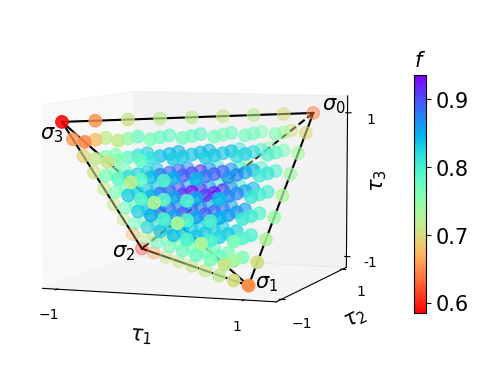

In [24]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import csv
from matplotlib import cm
def graficar(documento): 
    file = open(documento)
    csvreader = csv.reader(file)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
        
    ax.plot([1,1],[1,-1],[1,-1],'k')
    ax.plot([1,-1],[1,1],[1,-1],'k--')
    ax.plot([1,-1],[1,-1],[1,1],'k')
    ax.plot([-1,1],[1,-1],[-1,-1],'k')
    ax.plot([-1,-1],[1,-1],[-1,1],'k')
    ax.plot([1,-1],[-1,-1],[-1,1],'k')
    #     plt.plot(0,0,0,'ko')
    ax.plot(1.18,1,1.08,'ko',markersize=0.1)

    ax.text(1.1,1,1.05,'$\sigma_0$',size=15)
    ax.text(1.1,-1.1,-1,'$\sigma_1$',size=15)
    ax.text(-1.05,0.3,-1,'$\sigma_2$',size=15)
    ax.text(-1.25,-1,0.77,'$\sigma_3$',size=15)
#     ax.text(0,0,0,'O',size=20)

    ax.set_xlabel(r'$\tau_1$', fontsize=15)
    ax.set_ylabel(r'$\tau_2$',fontsize=15)

    plt.xticks([-1,1],fontsize=10)
    plt.yticks([-1,1],fontsize=10)
    ax.set_zticks([-1, 1])
    ax.set_zticklabels([-1,1],fontsize=10)
    ax.set_zlabel(r'$\tau_3$', fontsize=15, rotation = 0,
                 labelpad=10)
    
#     ax.text(2,0,0,r'$\tau_3$',size=15,rotation=-90)

    xs = []
    ys = []
    zs = []
    four= []
    for row in csvreader:
        if row[0] == 'lambda1':
            continue
        xs.append(float(row[0]))
        ys.append(float(row[1]))
        zs.append(float(row[2]))
        four.append(float(row[3]))

        
    ffour = four
    colors = cm.rainbow_r((np.array(ffour)-min(ffour))/(max(ffour)-min(ffour)))
#     colors = cm.rainbow_r(ffour)

    colmap = cm.ScalarMappable(cmap=cm.rainbow_r)
    print(min(ffour),max(ffour))
    
    colmap.set_array([min(ffour),max(ffour)])
#     colmap.set_array([0,1])
    
    
    yg = ax.scatter(xs, ys, zs, c=colors, marker='o',s=80)
    cb = fig.colorbar(colmap,fraction=0.024, pad=0.07)
    cb.ax.tick_params(labelsize=15) 
    
    cb.ax.set_title("$f$",fontsize=15)
    ax.view_init(6,290)

        
    ax.zaxis.labelpad=-5
    ax.grid(False)
    plt.show()


graficar('Resultados/ibmq_limatetra9/fidelidades_diam1.csv')


cb = fig.colorbar(colmap,fraction=0.024, pad=0.07)
    cb.ax.tick_params(labelsize=15) 

C:\Users\tbasi\AppData\Local\Temp\ipykernel_12060\2092780473.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(colmap,fraction=0.024, pad=0.07)


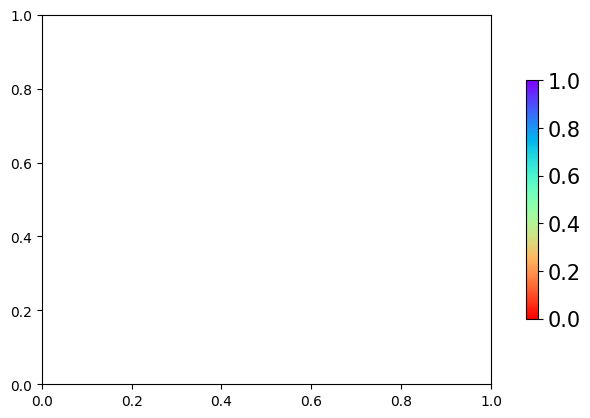

In [29]:
fig = plt.figure()

file = open('Resultados/ibmq_limatetra9/fidelidades_diam1.csv')
csvreader = csv.reader(file)

xs = []
ys = []
zs = []
four= []

for row in csvreader:
    if row[0] == 'lambda1':
        continue
    xs.append(float(row[0]))
    ys.append(float(row[1]))
    zs.append(float(row[2]))
    four.append(float(row[3]))

        
ffour = four
colors = cm.rainbow_r((np.array(ffour)-min(ffour))/(max(ffour)-min(ffour)))
#     colors = cm.rainbow_r(ffour)

colmap = cm.ScalarMappable(cmap=cm.rainbow_r)
    
    
cb = fig.colorbar(colmap,fraction=0.024, pad=0.07)
cb.ax.tick_params(labelsize=15) 